# Compute rotary spectra on mitgcm outputs (SSU and SSV)



---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.0:51286 Dashboard: http://10.148.1.0:8787/status,Cluster Workers: 60 Cores: 240 Memory: 3000.00 GB


---

# All faces

## compute and store spectra for all faces

In [5]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

v_u = 'SSU'
v_v = 'SSV'

## open files, nc files (SSU,SSV) ##
ncdata_dir = '/home1/scratch/xyu/mit_nc_new/'

# dir where spectra will be stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/'

print(ncdata_dir)
print(E_dir)

# number of fies to load for each face (1 file = 10 days --- well, now it depends...)
Nf = 2

# grid file
mgrid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])


/home1/scratch/xyu/mit_nc_new/
/home1/scratch/xyu/mit_spec/zavg_UV/


_______
# FFT with blocks

In [25]:
face_60 = [0, 3, 6, 9, 12] # some key faces
print(face_60)

[0, 3, 6, 9, 12]


In [ ]:
## Here we do DFT on u+iv ##

for face in face_60:
#for face in range(8,9):
    
    # SSU #
    filenames_u = sorted(glob(ncdata_dir+v_u+'_f%02d_t*.nc' %(face)))
    filenames_u = filenames_u[:Nf]
    
    # SSV #
    filenames_v = sorted(glob(ncdata_dir+v_v+'_f%02d_t*.nc' %(face)))
    filenames_v = filenames_v[:Nf]    
    
    # Grid #
    grid = mgrid.isel(face=face)
    
    # Read SSU #
    ds = xr.open_mfdataset(filenames_u, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    chunks={'time': len(ds['time'])}
    ds = ds.chunk(chunks)    

    # Read SSV #
    ds_v = xr.open_mfdataset(filenames_v, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    chunks_v={'time': len(ds_v['time'])}
    ds_v = ds_v.chunk(chunks_v)
    
    # Merge into one xarray dataset #
    ds = xr.merge([ds_v,ds])
    
    
    nfft = 1440  # 24hours * 60 = 60 days 
    noverlap = nfft/2
    window = np.hanning(nfft)

    SSU = ds[v_u]
    T = np.arange(0, len(SSU.time)-int(nfft/2), int(nfft/2))
    print(T)

    # loop for different blocks
    for t in T:
        
        uv_complex = (ds[v_u].isel(time=slice(t,t+nfft)) + 1j*ds[v_v].isel(time=slice(t,t+nfft)))    
        uv_fft_complex = xrft.dft(window*uv_complex.fillna(0.), dim=['time'], shift=False, detrend='linear')
        E_uv = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/nfft*3600
        E_uv = np.real(E_uv).rename('E_uv')
        E_uv = xr.merge([E_uv, grid])
        file_E = E_dir+'E_uv_f%02d_t%04d.nc'% (face,t)     
        E_uv.to_netcdf(file_E, mode='w')  
        print('time %d done'%t )
    
    print('face %d done'%face )

[   0  720 1440]


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 5.55 MB detected in task graph: 
  ("('__array_wrap__-75fa44123008b418705d4eb4126d563 ... e169>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_futu

______

# Blocks averaging and store

In [ ]:
face_60 = [0, 3, 6, 9, 12]
print(face_60)

In [16]:
#for face in range(8,9):
for face in face_60:

    filenames = sorted(glob(E_dir+'E_uv_f%02d_t0*.nc' %(face)))
    
    ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='blocks', compat='equals')    
    E_uv = (ds.E_uv).mean(dim='blocks')    
    file_E = E_dir+'E_uv_f%02d.nc'%face   
    E_uv.to_netcdf(file_E, mode='w')  
    

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


______
## zonally average spectra

Faces are processed independantly, this alleviate the computational burden on the scheduler (large task graph issue)


In [10]:
face_60 = [0, 3, 6, 9, 12]
print(face_60)

[5, 7]


In [ ]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
#for face in range(8,9):
for face in face_60:

    file_E = E_dir+'E_uv_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E_uv).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E_uv.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')

    ds_zavg.to_netcdf(E_dir+'E_rotary_zavg_f%02d.nc'%face, mode='w')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

_______

# 1. load and plot zonally averaged spectra


In [6]:
filenames = sorted(glob(E_dir+'E_rotary_zavg_f*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')
print(ds)

CPU times: user 72 ms, sys: 28 ms, total: 100 ms
Wall time: 99.4 ms
<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1439, lat: 120)
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
Dimensions without coordinates: face
Data variables:
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 1439), chunksize=(1, 120, 1439)>
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>


In [7]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 

print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(120, 1439)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


### 1.1    full colorscale [-1, 4]

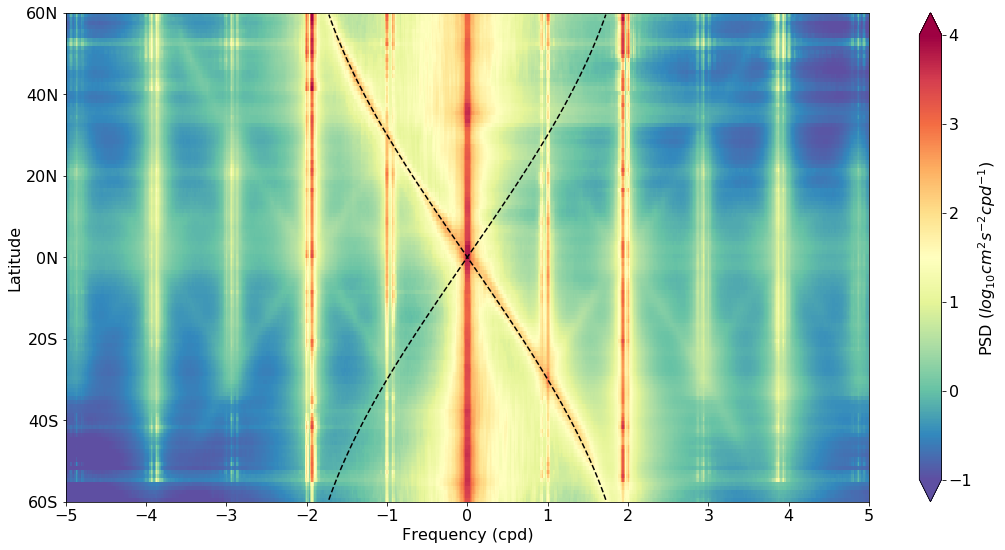

In [8]:
# Figure #

plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1., vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            

# x,y ticks

ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)


# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')



### 1.2 using Shane's colorscale [0.5, 4]

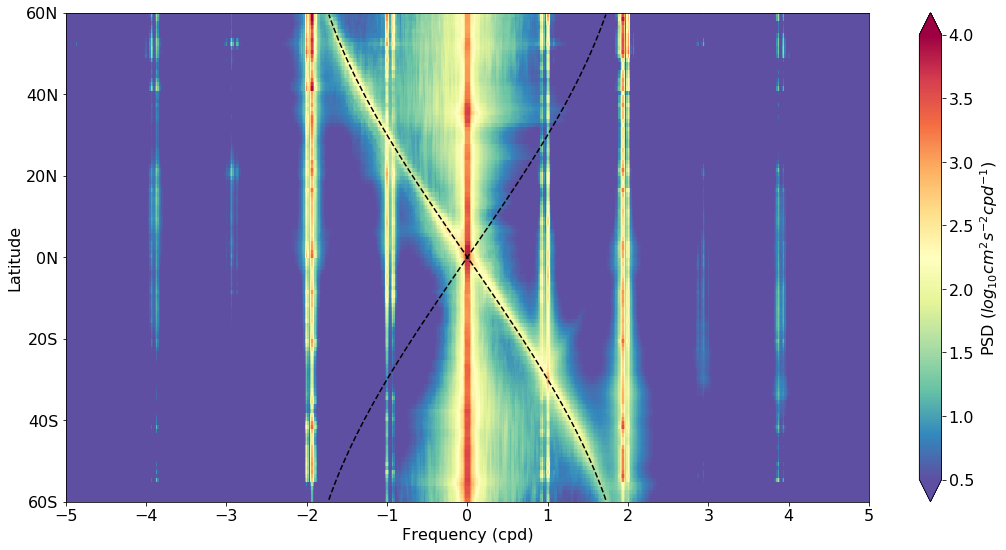

In [9]:
# Figure #

plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=0.5, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            

# x,y ticks

ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)


# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_uv_face0-12.png')


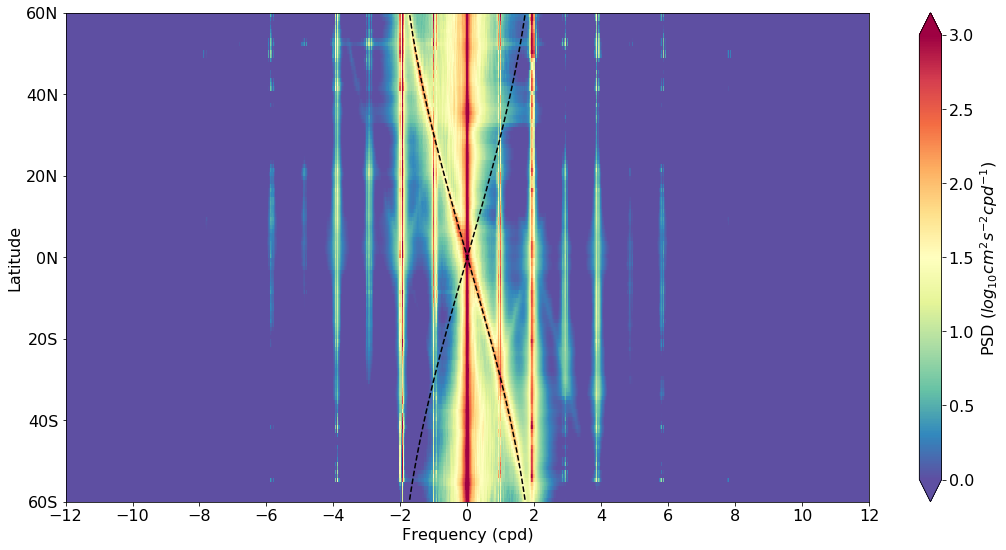

In [10]:
# Figure #

plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-0., vmax=3., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16)
            

# x,y ticks

ax.set_xticks([-12., -10., -8., -6., -4., -2., 0., 2., 4., 6., 8., 10., 12.])
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)


# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_uv.png')




# 2. Band-frequency integral

In [11]:
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(120, 1439)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [12]:
df=E.freq_time[1]-E.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)


In [13]:
## total energy_lat mean

(E*df).sum(dim='freq_time').mean().compute()

<xarray.DataArray ()>
array(0.029609)

## 2.1 Total energy vs tidal frequencies 

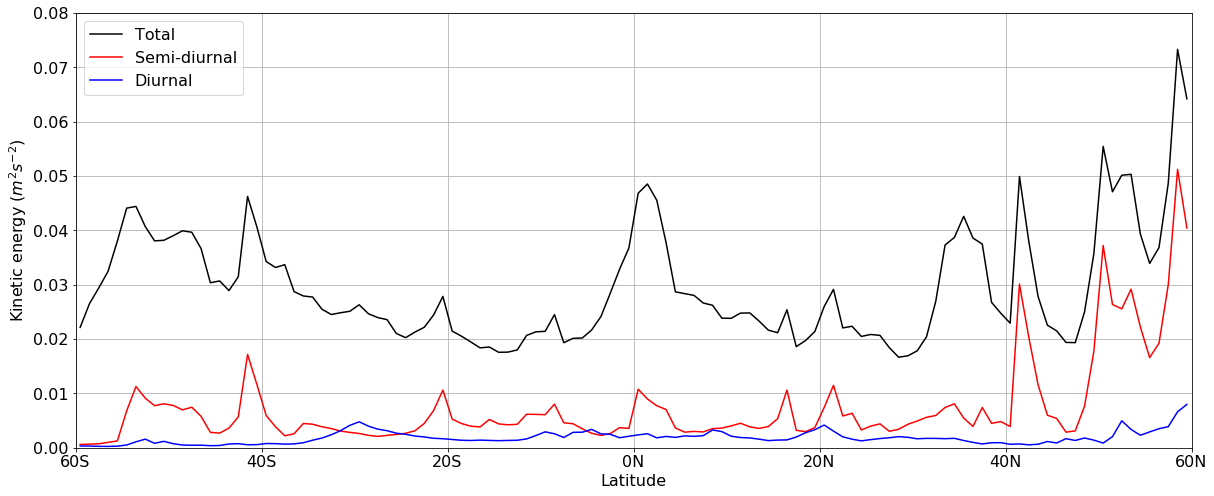

In [14]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Semi-diurnal', 'Diurnal']

(E*df).sum(dim='freq_time').plot(color='black', label=labels[0]) # total energy
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[1]) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[2]) # energy around diurnal frequencies
ax.legend(prop={'size': 16}); ax.grid()


# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylim([0,0.08])


ax.set_xlabel('Latitude',fontsize=16)
ax.set_ylabel('Kinetic energy ($m^2 s^{-2}$)',fontsize=16)
ax.tick_params(labelsize=16)


## 2.2 Total energy vs near-inetial energy

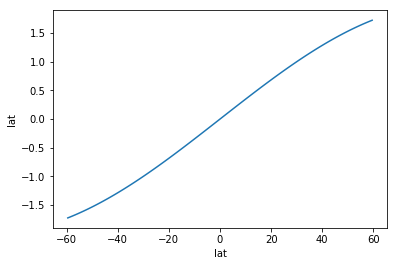

In [15]:
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi
f_cpd.plot()

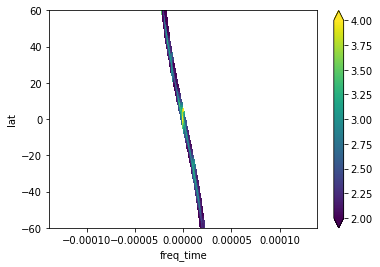

In [31]:
np.log10(E.where(abs(E.freq_cpd+f_cpd)<.2, other=0.)).plot(vmin=2, vmax=4)

(0, 0.08)

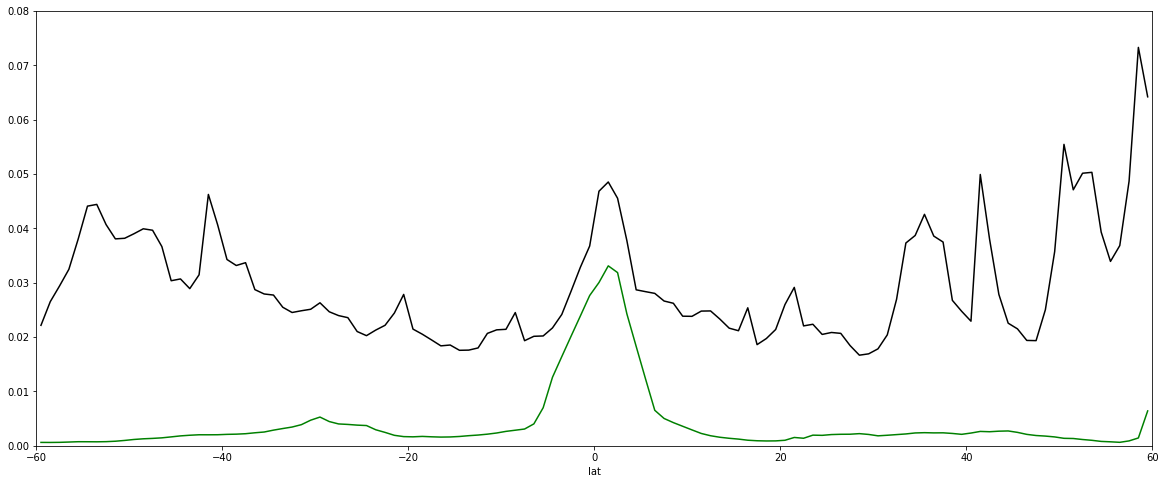

In [43]:
fig, ax = plt.subplots(figsize=(20,8))

(E*df).sum(dim='freq_time').plot(color='black') # total energy
(E.where(abs(E.freq_cpd+f_cpd)<.2, other=0.)*df).sum(dim='freq_time').plot(color='green')

ax.set_xlim([-60,60])
ax.set_ylim([0,0.08])

## 2.3 Total energy vs low-frequency (>10 days) energy

(0, 0.08)

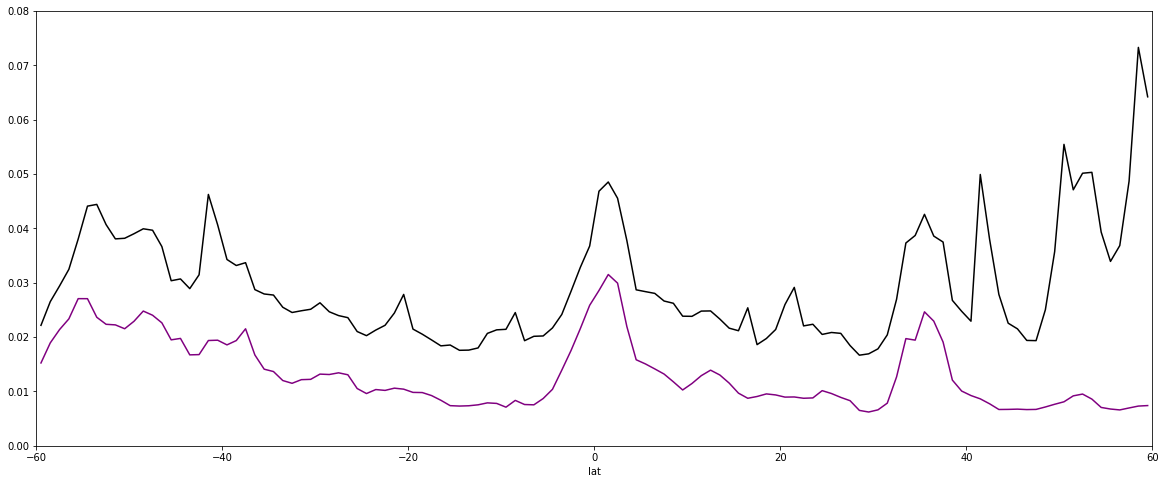

In [44]:
fig, ax = plt.subplots(figsize=(20,8))

(E*df).sum(dim='freq_time').plot(color='black') # total energy

(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple')   # energy at low frequencies (> 10 days) 

ax.set_xlim([-60,60])
ax.set_ylim([0,0.08])

## 2.4 Total energy vs Band-frequency integral

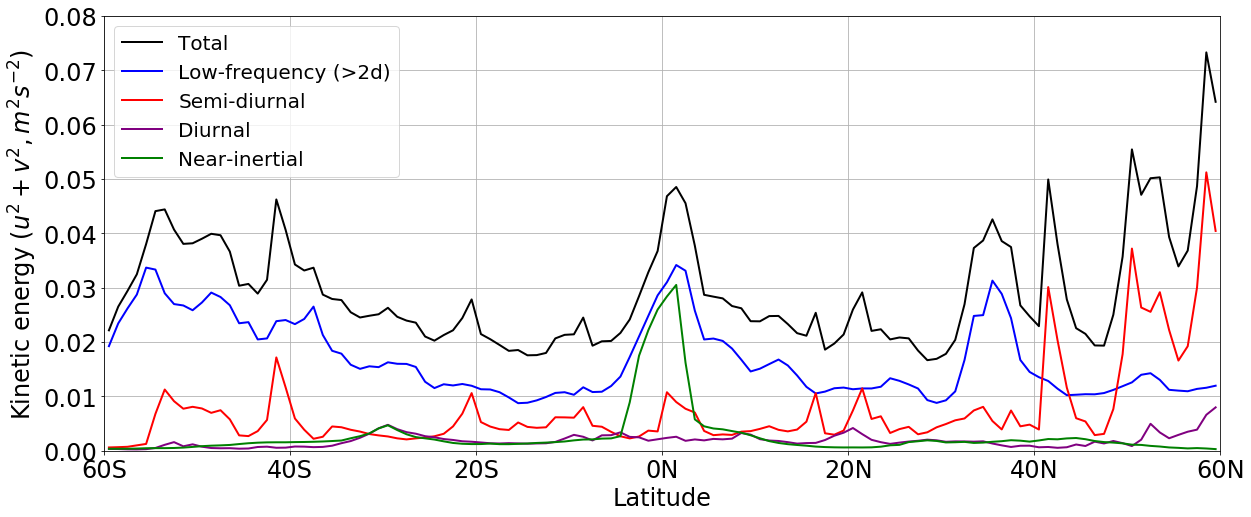

In [17]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']


(E*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.0) # total energy
(E.where((abs(E.freq_cpd)>0) & (abs(E.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.0)   # energy at low frequencies (> 5 days) 
(E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.0) # energy around semi-diurnal frequencies
(E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.0) # energy around diurnal frequencies
(E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').plot(color='green', label=labels[4], linewidth=2.0) # energy around f
ax.legend(prop={'size': 20}); ax.grid()


# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.08])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Freq-integral KE.png')

# 3. face-averaged spectra

In [20]:
filenames_u = sorted(glob(E_dir+'E_uv_f*.nc'))

# Grid #
face = 1
grid = mgrid.isel(face=face)
    
# Read SSU #
ds = xr.open_mfdataset(filenames_u, chunks={'i':10, 'j':432}, concat_dim='face', compat='equals')
chunks={'face': len(ds['face'])}
ds = ds.chunk(chunks)    
print(ds)

<xarray.Dataset>
Dimensions:            (face: 13, freq_time: 1440, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
  * face               (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC                 (face, i, j) float32 dask.array<shape=(13, 4320, 4320), chunksize=(13, 10, 432)>
    YC                 (face, i, j) float32 dask.array<shape=(13, 4320, 4320), chunksize=(13, 10, 432)>
    rA                 (face, i, j) float32 dask.array<shape=(13, 4320, 4320), chunksize=(13, 10, 432)>
    Depth              (face, i, j) float32 dask.array<shape=(13, 4320, 4320), chunksize=(13, 10, 432)>
Data variables:
    E_uv               (face, i, j, freq_time) float64 dask.array<shape=(13, 4320, 4320, 1440), chunksize=(13, 10, 432, 

In [21]:
print(E_dir)

/home1/scratch/xyu/mit_spec/zavg_UV/


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-57.50102615, -57.40102615, -57.30102615, -57.20102615,
        -57.10102615, -57.00102615, -56.90102615, -56.80102615,
        -56.70102615, -56.60102615, -56.50102615]),
 <a list of 10 Patch objects>)

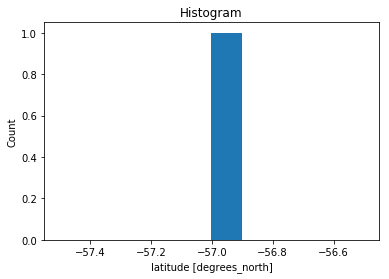

In [22]:
ds.YC.isel(face=1,i=10,j=0).plot()

In [35]:
E_uv = (ds.E_uv).where(ds.YC>0.).mean(dim=('i','j','face'))   
file_E = E_dir+'E_uv_north_mean.nc'  
%time E_uv.to_netcdf(file_E, mode='w')  

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 174.68 MB detected in task graph: 
  ("('mean_agg-aggregate-2228c8d029a11cee94be0fc10b7 ... 723a>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils

CPU times: user 1h 25min 5s, sys: 1min 21s, total: 1h 26min 26s
Wall time: 1h 56min 4s


In [ ]:
E_uv = (ds.E_uv).where(ds.YC<0.).mean(dim=('i','j','face'))   
file_E = E_dir+'E_uv_south_mean.nc'  
%time E_uv.to_netcdf(file_E, mode='w')  

In [6]:
#filenames_u = sorted(glob(E_dir+'E_uv_allface_mean.nc'))
filenames_u = sorted(glob(E_dir+'E_uv_south_mean.nc'))
face = 1
# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds = xr.open_mfdataset(filenames_u)
print(ds)

<xarray.Dataset>
Dimensions:                        (freq_time: 1440)
Coordinates:
  * freq_time                      (freq_time) float64 0.0 1.929e-07 ...
    freq_time_spacing              float64 ...
Data variables:
    __xarray_dataarray_variable__  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [7]:
E_south = ds.__xarray_dataarray_variable__
E_south = E_south.assign_coords(freq_time=ds.__xarray_dataarray_variable__.freq_time * 86400.) 
print(E_south)

<xarray.DataArray '__xarray_dataarray_variable__' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [8]:
E0_south = E_south/8.64

In [9]:
#filenames_u = sorted(glob(E_dir+'E_uv_allface_mean.nc'))
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/'
filenames_u = sorted(glob(E_dir+'E_uv_north_mean.nc'))

# Grid #
grid = mgrid.isel(face=face)
# Read SSU #
ds0 = xr.open_mfdataset(filenames_u)
print(ds0)

<xarray.Dataset>
Dimensions:                        (freq_time: 1440)
Coordinates:
  * freq_time                      (freq_time) float64 0.0 1.929e-07 ...
    freq_time_spacing              float64 ...
Data variables:
    __xarray_dataarray_variable__  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [10]:
E_north = ds0.__xarray_dataarray_variable__
E_north = E_north.assign_coords(freq_time=ds0.__xarray_dataarray_variable__.freq_time * 86400.) 
print(E_north)

<xarray.DataArray '__xarray_dataarray_variable__' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...


In [11]:
E0_north = E_north/8.64

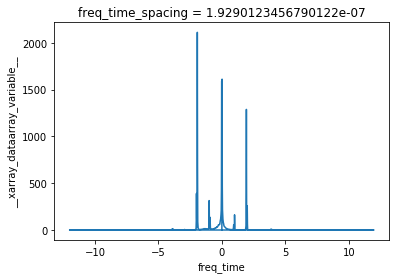

In [12]:
E0_north.plot()

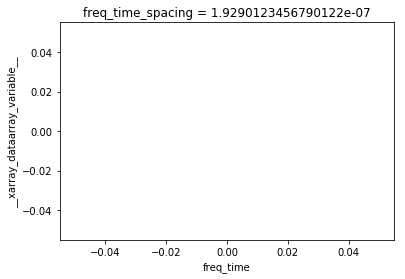

In [13]:
E0_south.plot()

In [16]:
E0_south_anti = E0_south.where(E0_south.freq_time>0)
print(E0_south_anti)

E0_north_anti = E0_north.where(E0_north.freq_time<0)
E0_north_anti = E0_north_anti.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_anti)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


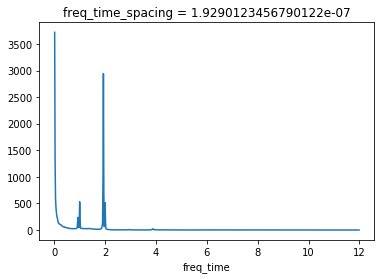

In [17]:
E0_anti = E0_north_anti + E0_south_anti
E0_anti.plot()

In [18]:
E0_south_cycl = E0_south.where(E0_south.freq_time<0)
print(E0_south_cycl)

E0_north_cycl = E0_north.where(E0_north.freq_time>0)
E0_north_cycl = E0_north_cycl.assign_coords(freq_time=E_north.freq_time * -1.) 
print(E0_north_cycl)

<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
<xarray.DataArray (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 -0.01667 -0.03333 -0.05 ...
    freq_time_spacing  float64 ...


In [19]:
E0_cycl = E0_north_cycl + E0_south_cycl
E0_cycl = E0_cycl.assign_coords(freq_time=E0_cycl.freq_time * -1.) 

print(E0_cycl)

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07


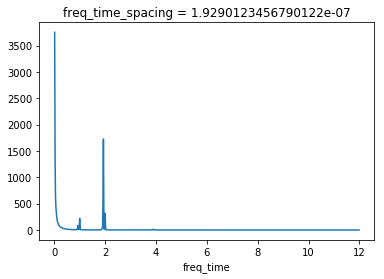

In [20]:
E0_cycl.plot()

No handles with labels found to put in legend.


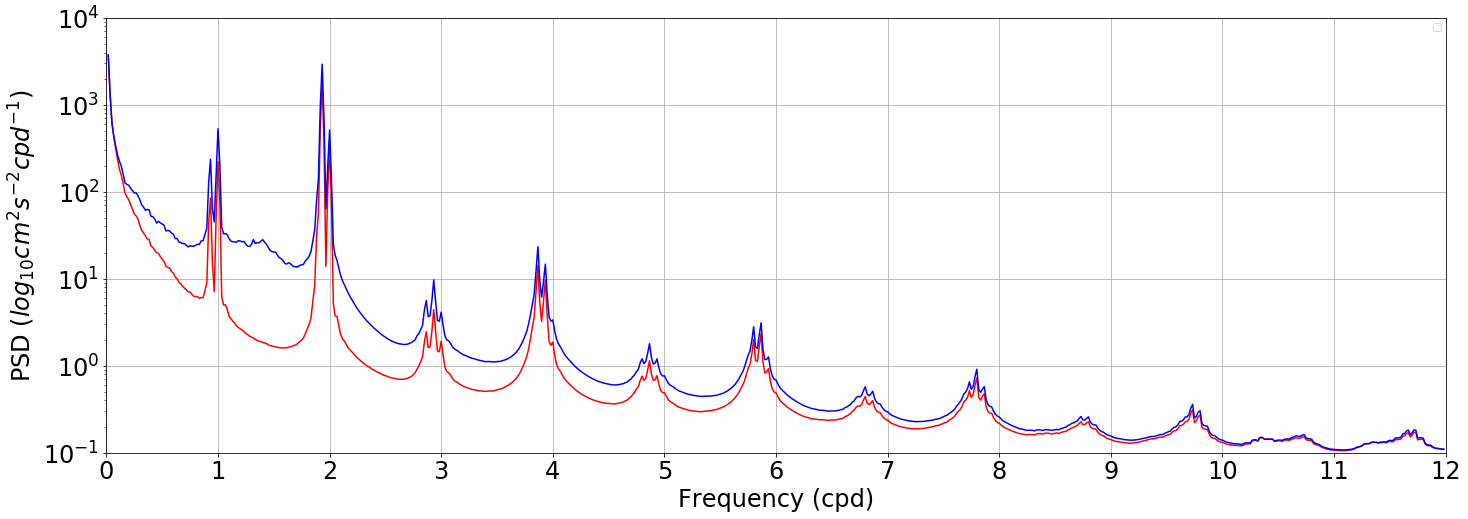

In [22]:

fig, ax = plt.subplots(figsize=(24,8))

(E0_cycl.where(E0_cycl.freq_time>0)).plot(ax=ax,color='red')
((E0_anti).where(E0_anti.freq_time>0)).plot(ax=ax,color='blue')

ax.legend(); ax.grid()
ax.set_yscale('log')

ax.set_ylim([1e-1,1e4])
ax.set_xlim([0,12])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])


# Semi-diurnal frequencies#
#ax.plot([24/12.42,24/12.42],[1e-1,1e0],'k--') # M2
#ax.plot([24/12,24/12],[1e-1,1e0],'k--')  # S2

# Diurnal frequencies#
#ax.plot([24/23.93,24/23.93],[1e-1,1e0],'k--')      # K1
#ax.plot([24/25.81,24/25.81],[1e-1,1e0],'k--') # O1

ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Gobally averaged PSD.png')

# 4. coastal vs open ocean

In [42]:
face = 5

file_E = E_dir+'E_uv_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 10, 'j': 432})
ds = ds.assign_coords(freq_cpd=ds.freq_time * 86400.)
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
Data variables:
    E_uv               (i, j, freq_time) float64 dask.array<shape=(4320, 4320, 1440), chunksize=(10, 432, 1440)>


In [43]:
%time E = ds['E_uv'].where(ds.Depth>500).mean(dim=('i','j')).load()

CPU times: user 8min 2s, sys: 30.9 s, total: 8min 33s
Wall time: 14min 25s


In [47]:
%time E1 = ds['E_uv'].mean(dim=('i','j')).load()

CPU times: user 5min 58s, sys: 27.6 s, total: 6min 26s
Wall time: 12min 55s


In [44]:
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (freq_time: 1440)>
array([1.934056e-26, 2.382013e+04, 6.896570e+03, ..., 2.635788e+03,
       6.864907e+03, 2.383545e+04])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    face               int64 5
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [48]:
E1 = E1.assign_coords(freq_cpd=E1.freq_time * 86400.) 
print(E1)

<xarray.DataArray 'E_uv' (freq_time: 1440)>
array([1.586817e-26, 1.933543e+04, 5.477999e+03, ..., 2.203710e+03,
       5.357299e+03, 1.933703e+04])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    face               int64 5
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [49]:
E2 = E1/8.64

In [45]:
E0 = E/8.64

No handles with labels found to put in legend.
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


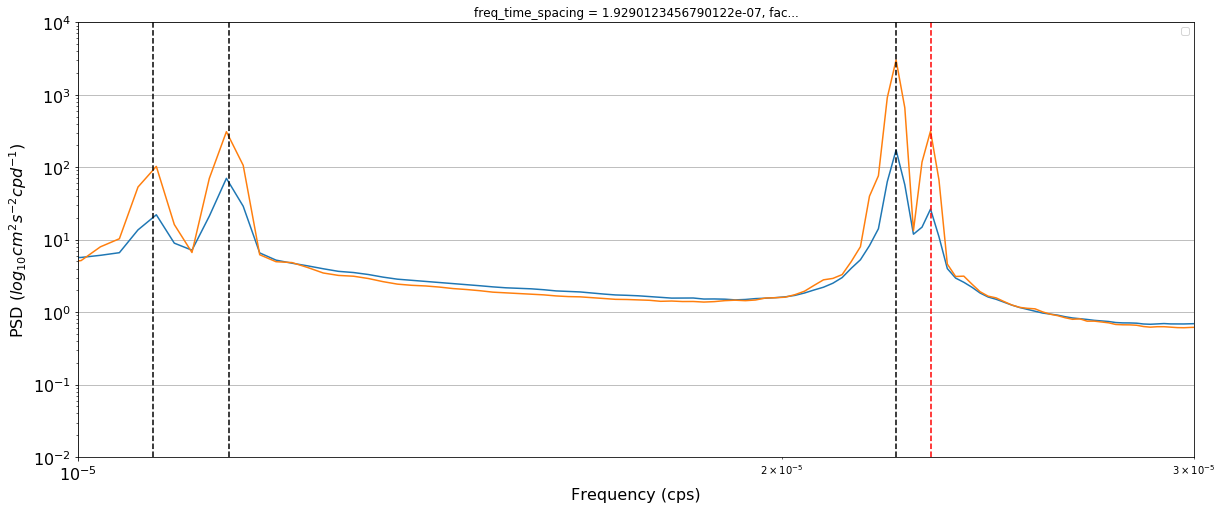

In [51]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
E2.where(E2.freq_time>0).plot(ax=ax)


#ax.set_ylabel(''); 
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-5,3*1e-5])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-2,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

# 5. Spatial variablity of some specific frequencies (e.g. M2,K1)

In [ ]:
face = 5

file_E = E_dir+'E_uv_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 10, 'j': 432})
ds = ds.assign_coords(freq_cpd=ds.freq_time * 86400.)
print(ds)

In [41]:
print(ds.freq_cpd[120]) # 1 cpd

<xarray.DataArray 'freq_cpd' ()>
array(2.)
Coordinates:
    freq_time          float64 2.315e-05
    freq_time_spacing  float64 ...
    face               int64 ...
    freq_cpd           float64 2.0


In [42]:
eta = ds['E_uv'].isel(freq_time=120, i=slice(2500,4320), j=slice(0,2000)).persist() # 2 cpd

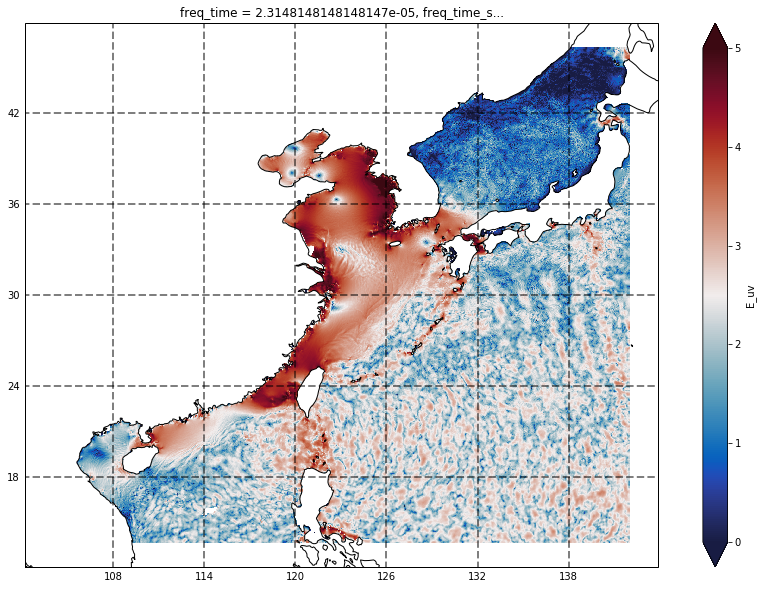

In [43]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 5, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [44]:
eta = ds['E_uv'].isel(freq_time=60, i=slice(2500,4320), j=slice(0,2000)).persist() # 1 cpd

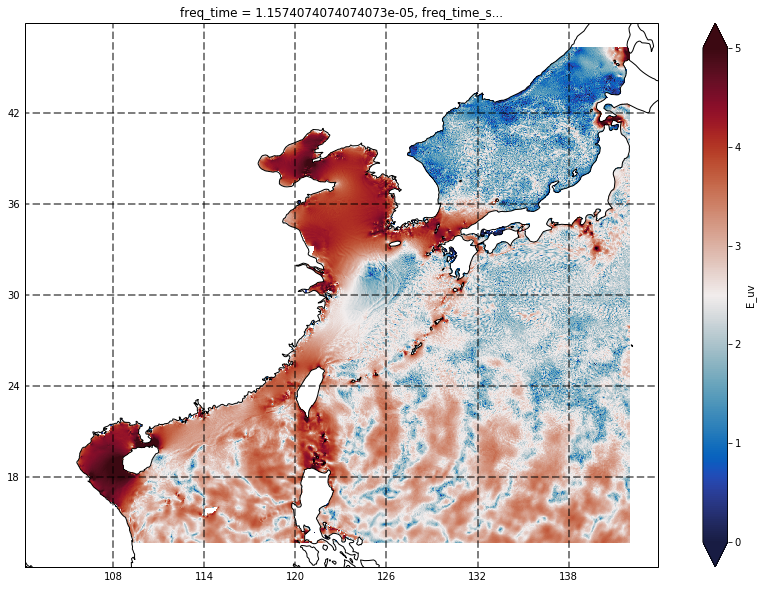

In [45]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 5, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

# 6. Spatial-averaged spectra

In [5]:
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV_nowindow/'

In [6]:
face = 1

file_E = E_dir+'E_uv_f%02d_t0000.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 10, 'j': 432})
ds = ds.assign_coords(freq_cpd=ds.freq_time * 86400.)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:            (freq_time: 1440, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
Data variables:
    E_uv               (i, j, freq_time) float64 dask.array<shape=(4320, 4320, 1440), chunksize=(10, 432, 1440)>

 data size: 215.3 GB


In [7]:
%time E = ds['E_uv'].mean(dim=('i','j')).load()

CPU times: user 1min 21s, sys: 3.46 s, total: 1min 25s
Wall time: 9min 35s


In [8]:
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray 'E_uv' (freq_time: 1440)>
array([1.064459e-08, 2.279952e+04, 1.702352e+04, ..., 9.479996e+03,
       1.745471e+04, 2.369208e+04])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    face               int64 1
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


### cm^2 s^-2/cpd

In [9]:
E0 = E/8.64

No handles with labels found to put in legend.


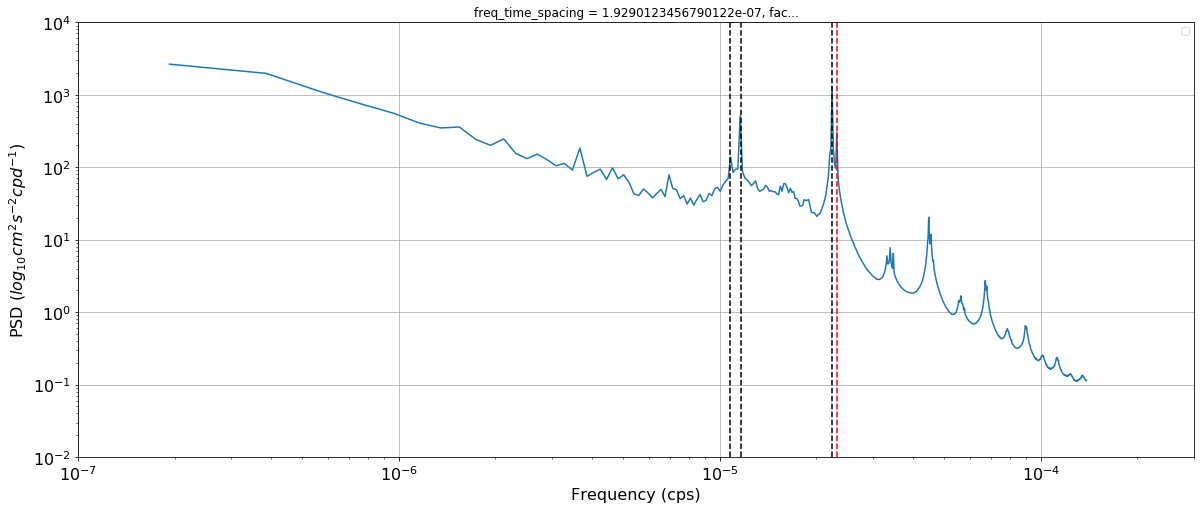

In [14]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-2,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

No handles with labels found to put in legend.


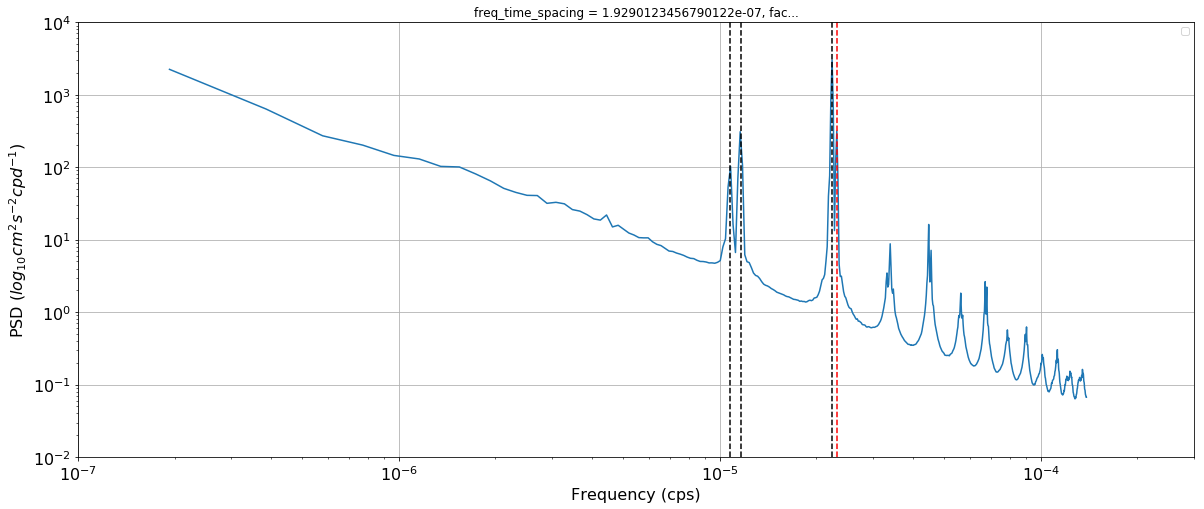

In [66]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-2,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

No handles with labels found to put in legend.


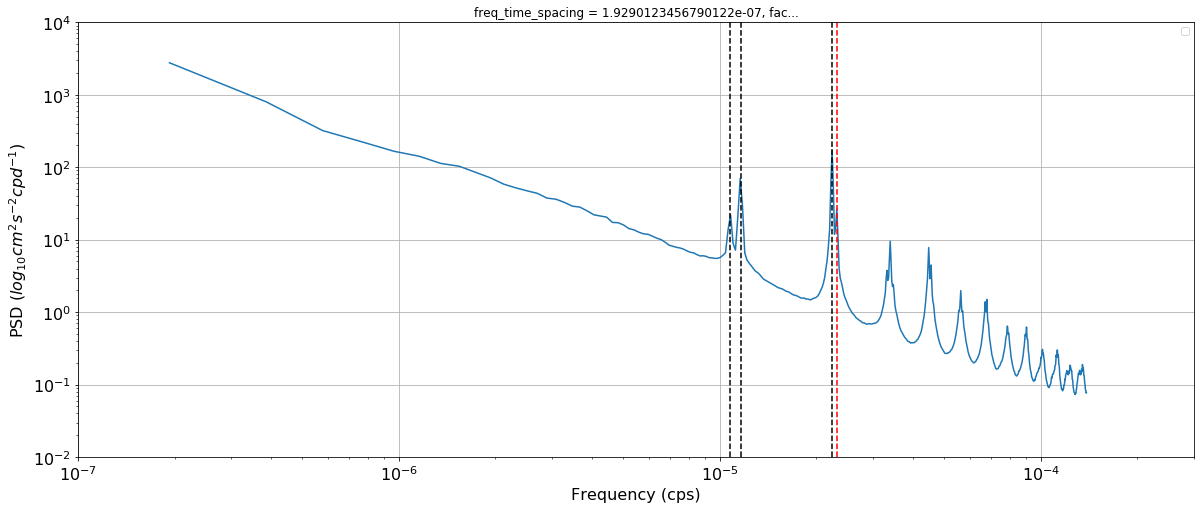

In [46]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-2,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

### m^2 s^-2/cpd

In [67]:
E1 = E/86400

No handles with labels found to put in legend.


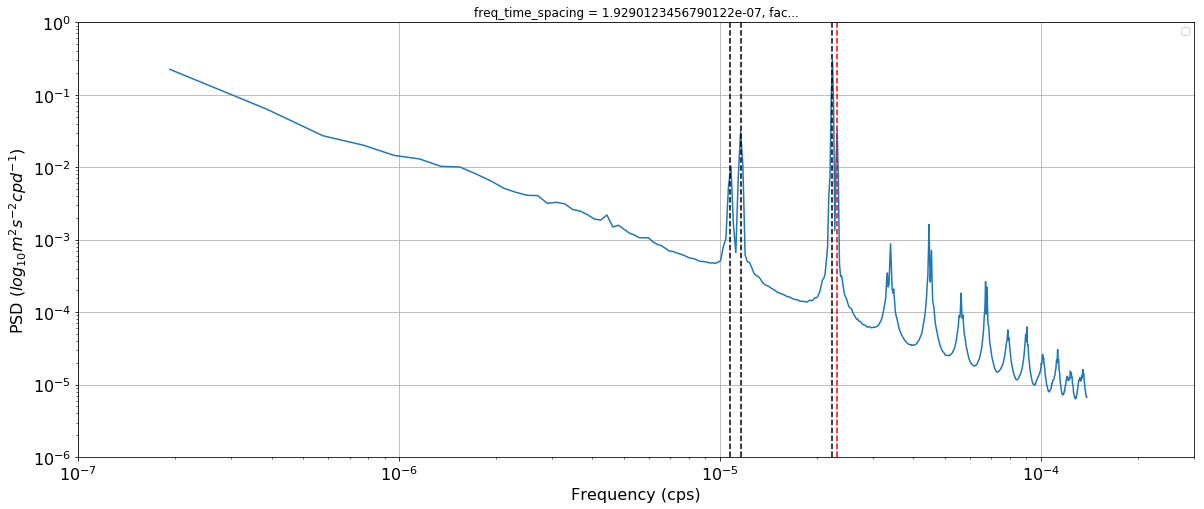

In [72]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E1.where(E1.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-6,1e0])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-6,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-6,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-6,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-6,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} m^2 s^{-2} cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

### m^2 s^-2/cph

In [74]:
E2 = E/0.36

No handles with labels found to put in legend.


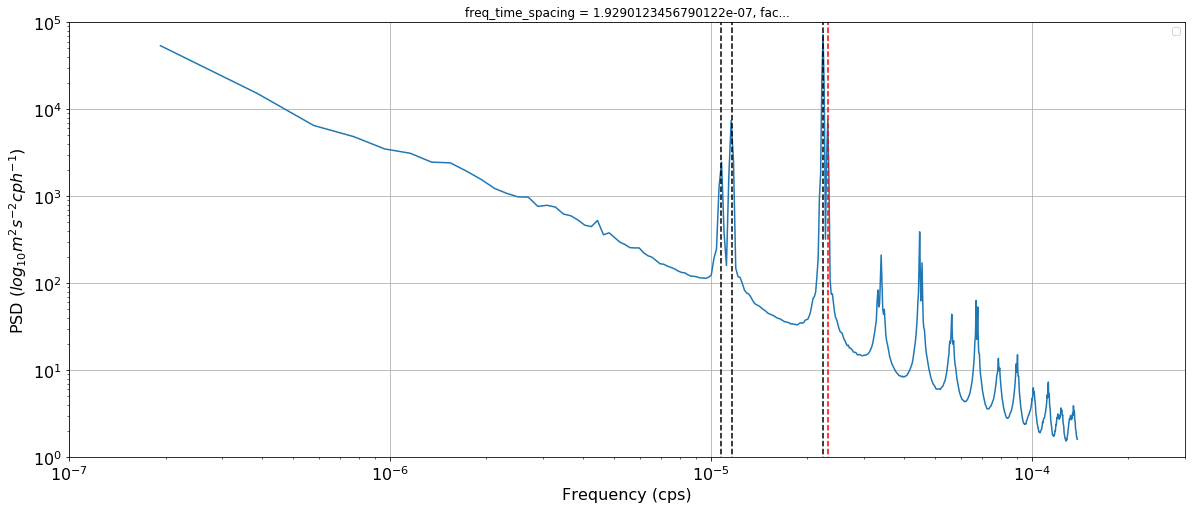

In [84]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E2.where(E2.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')


#ax.set_ylabel(''); 
ax.set_ylim([1e0,1e5])
ax.set_xlim([1e-7,3*1e-4])

# Semi-diurnal frequencies#
ax.plot([1/12.42/3600,1/12.42/3600],[1e-6,1e6],'k--') # M2
ax.plot([1/12/3600,1/12/3600],[1e-6,1e6],'r--')  # S2

# Diurnal frequencies#

ax.plot([1/23.93/3600,1/23.93/3600],[1e-6,1e6],'k--')      # K1
ax.plot([1/25.81/3600,1/25.81/3600],[1e-6,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} m^2 s^{-2} cph^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cps)',fontsize=16)
ax.tick_params(labelsize=16)

---

In [14]:
cluster.scheduler.close()

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>

In [87]:
client.restart()

Client Scheduler: tcp://10.148.1.6:35881 Dashboard: http://10.148.1.6:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B
